In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml
import itertools
import PyNAFF

As a useful exercise to put in practice what we learned so far, we will now
track particles, obtain the tunes and plot the footprint of the particles
Let's setup the collider as always

In [2]:
collider = xt.Multiline.from_json('../data/collider_thin.json')
collider.build_trackers()
with open('../data/config.yaml', "r") as fid:
        config = yaml.safe_load(fid)
    
twiss_b1 = collider['lhcb1'].twiss()
ctx = xo.ContextCpu()
collider.vars['i_oct_b1'] = 250

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


We define 5 particles with different initial amplitudes along x (the same can be done for y).
We use the twiss to retrieve the sigma_x at the starting point.

In [3]:
betx = twiss_b1['betx'][0]
bety = twiss_b1['bety'][0]
normal_emitt_x = 2.5e-6
normal_emitt_y = 2.5e-6
particle_0 = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
sigma_x = np.sqrt(betx*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))[0]
sigma_y = np.sqrt(bety*normal_emitt_y/(particle_0.gamma0*particle_0.beta0))[0]
x = np.linspace(sigma_x, 3*sigma_x, 5)
px = np.zeros(5)
y = np.zeros(5)
py = np.zeros(5)
zeta = np.zeros(5)
delta = np.zeros(5)
my_particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x = x, px = px,
                    y = y, py = py, zeta = zeta, delta = delta)

Now we want to track the particles for several turns, we can do it with the tracker method.

In [4]:
n_turns = 1024
collider['lhcb1'].track(my_particles, num_turns=n_turns,
              turn_by_turn_monitor=True)

Now we retrieve the tunes thanks to the NAFF algorithm.

In [5]:
xs = collider['lhcb1'].record_last_track.x
ys = collider['lhcb1'].record_last_track.y
qx_i = []
qy_i = []
for ii in range(len(x)):
    qx_i.append(PyNAFF.naff(xs[ii,:], turns=1023)[0][1])

We can see the tunes have been linearly shifted with respect to the initial amplitude.

This happens because the octupoles in the lattice perform a linear detuning with respect to the amplitude.

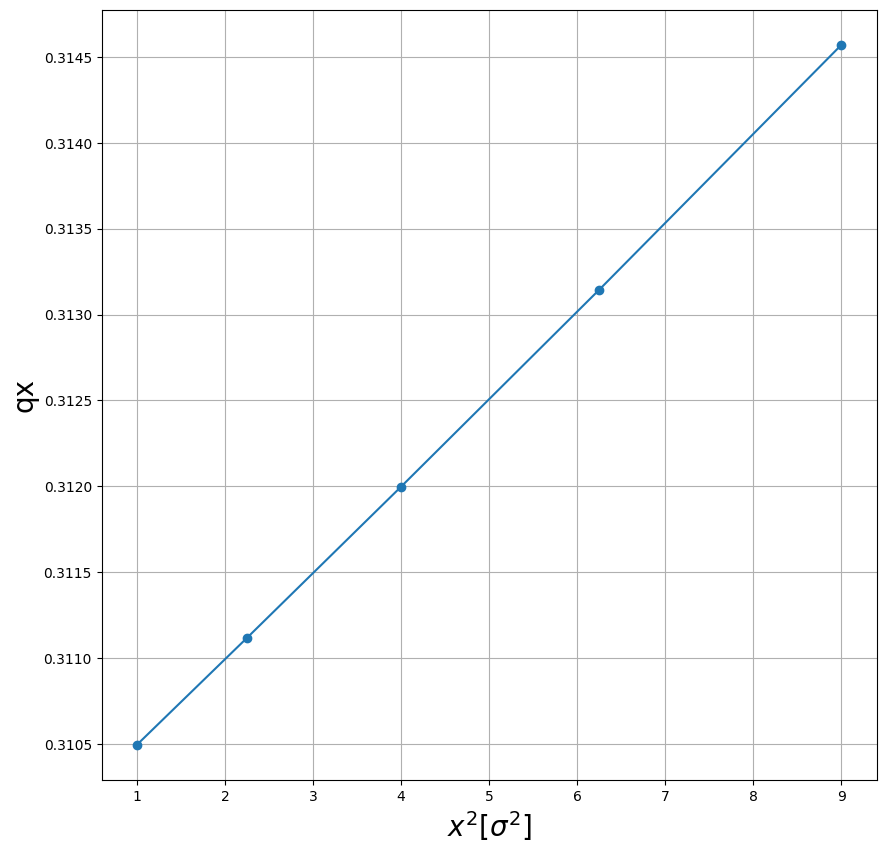

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(x**2/sigma_x**2,qx_i,'-o')
plt.xlabel(r'$x^{2}$[$\sigma^{2}$]', size = 20)
plt.ylabel(r'qx', size = 20)
plt.grid()

Xsuite provides a method to plot the footprint of the particles. In this way we can see what happens
simultaneously to x and y.
To show the direction of the detuning we will change the octupole strength thanks to the relative knob.

Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


Text(0.5, 1.0, 'Footprints for 3 different octupoles configurations')

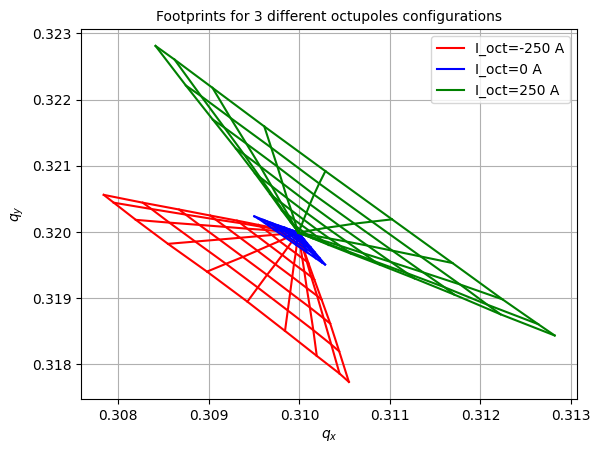

In [7]:
oct_curr = [ -250, 0, 250]
colors = ['r', 'b', 'g']
for ii in range(3):
    collider.vars['i_oct_b1'] = oct_curr[ii]
    fp0_jgrid = collider['lhcb1'].get_footprint(nemitt_x=normal_emitt_x, nemitt_y=normal_emitt_y,
                            mode='polar')
    fp0_jgrid.plot(color=colors[ii], label=f'I_oct={oct_curr[ii]} A')
plt.legend()
plt.grid()
plt.title('Footprints for 3 different octupoles configurations', size = 10)
